# Hate speech Detection using CNN





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional,GRU
from keras.layers import MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import sequence, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors
from sklearn import preprocessing
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from keras import optimizers

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.utils import class_weight

from sklearn import preprocessing
from sklearn.metrics import (
    classification_report as creport
)


# Data and AraVec2.0 (pre-trained word embeddings model) Loading

In [3]:
#pre-trained word embedding: https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0
"""
Citation:
Abu Bakr Soliman, Kareem Eisa, and Samhaa R. El-Beltagy, “AraVec:
A set of Arabic Word Embedding Models for use in Arabic NLP”,
in proceedings of the 3rd International Conference on 
Arabic Computational Linguistics (ACLing 2017), Dubai, UAE, 2017.
"""
! unzip '/content/drive/MyDrive/tweets_sg_300.zip'  

Archive:  /content/drive/MyDrive/tweets_sg_300.zip
  inflating: tweets_sg_300           
  inflating: tweets_sg_300.trainables.syn1neg.npy  
  inflating: tweets_sg_300.wv.vectors.npy  


In [4]:
# Word_embedding_path
embedding_path = '/content/tweets_sg_300'           #Twitter-Skipgram model-300d(trained on 77,600,000 Arabic tweets)

In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/Dataset.csv')
train_data

,Tweet,Class
0,هول هني ذاتن كانو كلاب الفلسطينية ضد حركة امل,hate
1,واحد مكيف إنه النهيق تبعه أموي شو بده يطلع منه,hate
2,هيدا لبناني لإنو عميل طز بهيك بلد معفن,hate
3,حاطين جبران باسيل وقاعدين جبران قال هيك جبران ...,abusive
4,هلق هيدا يلي طلع معك جبران باسيل متل جيري ماهر...,normal
...,...,...
2514,الكيزان زي النازيين واحد :قتلو وعذبو و حكمهم ...,hate
2515,وطنا جميل وشعبنا جميل بس هدونا البال بالسياسة ...,normal
2516,طيب شو القيمة يلي بيستفيدها المجتمع لو النسوان...,normal
2517,مارسيل غانم انتحر إعلامياً للتو ظهر عن طريق ال...,hate


In [6]:
print("Train data shape: {}". format(train_data.shape))

Train data shape: (2519, 2)


In [7]:
def get_embedding_matrix(word_index, embedding_index, vocab_dim):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, vocab_dim))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index.get_vector(word)
        except:
            pass
    print('Embedding matrix built.') 
    #print("Word index", word_index.items())
    #print(embedding_matrix) 
    return embedding_matrix


def get_init_parameters(path, ext=None):
    if ext == 'vec':
        word_model = KeyedVectors.load_word2vec_format(path).wv
    else:
        word_model = KeyedVectors.load(path).wv
    n_words = len(word_model.vocab)
    vocab_dim = word_model[word_model.index2word[0]].shape[0]
    index_dict = dict()
    for i in range(n_words):
        index_dict[word_model.index2word[i]] = i+1
    print('Number of words in the word embedding',n_words)
    #print('word_model', word_model)
    #print("index_dict",index_dict)
    return word_model, index_dict, n_words, vocab_dim

def get_max_length(text_data, return_line=False):
    max_length = 0
    long_line = ""
    for line in text_data:
        new = len(line.split())
        if new > max_length:
            max_length = new
            long_line = line
    if return_line:
        return long_line, max_length
    else:
        return max_length
    print("max",long_line,max_length)

def load_datasets(data_paths, header=True):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                if header:
                    header = False
                else:
                    temp = line.split(',')
                    x.append(temp[0])
                    y.append(temp[1].replace('\n', ''))
    max_length = get_max_length(x)
    print('Max length:', max_length)
    return x,y, max_length

def get_train_test(train_raw_text, test_raw_text, n_words, max_length):
    tokenizer = text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
   
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)

    return sequence.pad_sequences(train_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(test_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           word_index

def class_str_2_ind(x_train, x_test, y_train, y_test, classes, n_words, max_length):
    print('Converting data to trainable form...')
    y_encoder = preprocessing.LabelEncoder()
    y_encoder.fit(classes)
    y_train = y_encoder.transform(y_train)
    y_test = y_encoder.transform(y_test)
    #print(y_train)
    #print(y_test)
    train_y_cat = np_utils.to_categorical(y_train, len(classes))
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test, n_words, max_length)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of dev examples: ' + str(len(x_vec_test)))
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index


In [8]:
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(embedding_path) 

Number of words in the word embedding 331679


In [9]:
MAX_TEXT_LENGTH=58

In [10]:
# load train data
train_data_path=["/content/drive/MyDrive/OSACT4"]
X, y, MAX_TEXT_LENGTH = load_datasets(train_data_path)
CLASSES_LIST = np.unique(y)
print('Label categories: ' + str(CLASSES_LIST))

Max length: 58
Label categories: ['abusive' 'hate' 'normal']


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train, X_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(X_train, X_test, y_train, y_test, CLASSES_LIST, MAX_FEATURES, MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 2015
Number of dev examples: 504


In [13]:
print("Tokens number: "+str(len(word_index)))

Tokens number: 10605


In [14]:
# Sequence length
print("Original sequence length: "+str(MAX_TEXT_LENGTH))

Original sequence length: 58


#  CNN model building:

In [15]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    Create Neural Network With an Embedding layer
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)

    model = Conv1D(filters=25, kernel_size=5, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
   
    model = Dense(3, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)
    
    from keras import optimizers

    opt = optimizers.Adam(lr=0.0001)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs, TestCallback=TestCallback):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[TestCallback((x_test, y_test))])
    return history, model

In [16]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 58)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 58, 300)           3181800   
_________________________________________________________________
conv1d (Conv1D)              (None, 58, 25)            37525     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 25)            0         
_________________________________________________________________
flatten (Flatten)            (None, 725)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2178      
Total params: 3,221,503
Trainable params: 39,703
Non-trainable params: 3,1

In [17]:
time_start = time()
history, model = train_fit_predict(model,
                               X_train[:, :MAX_TEXT_LENGTH],
                               X_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y,
                               batch_size=500, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
5/5 [==============================] - 30s 193ms/step - loss: 1.1142 - accuracy: 0.2924 - val_loss: 1.0959 - val_accuracy: 0.3254

Testing loss: 1.0958609580993652, acc: 0.3253968358039856

Epoch 2/20
5/5 [==============================] - 0s 39ms/step - loss: 1.0950 - accuracy: 0.3285 - val_loss: 1.0902 - val_accuracy: 0.3552

Testing loss: 1.09017014503479, acc: 0.3551587164402008

Epoch 3/20
5/5 [==============================] - 0s 38ms/step - loss: 1.0856 - accuracy: 0.3572 - val_loss: 1.0855 - val_accuracy: 0.3829

Testing loss: 1.0855214595794678, acc: 0.3829365074634552

Epoch 4/20
5/5 [==============================] - 0s 39ms/step - loss: 1.0812 - accuracy: 0.3615 - val_loss: 1.0811 - val_accuracy: 0.4067

Testing loss: 1.08108651638031, acc: 0.4067460298538208

Epoch 5/20
5/5 [==============================] - 0s 39ms/step - loss: 1.0718 - accuracy: 0.3996 - val_loss: 1.0767 - val_accuracy: 0.4345

Testing loss: 1.0767014026641846, acc: 0.4345238208770752

Epoch 6

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
model.evaluate(X_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

1/1 [==============================] - 0s 99ms/step - loss: 1.0188 - accuracy: 0.5615


[1.018845558166504, 0.5615079402923584]

In [20]:
y_pred = np.argmax(model.predict(X_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred, target_names=["normal", "abusive", "hate"],digits=3))

              precision    recall  f1-score   support

      normal      0.529     0.578     0.552       173
     abusive      0.699     0.399     0.508       163
        hate      0.532     0.702     0.605       168

    accuracy                          0.562       504
   macro avg      0.587     0.560     0.555       504
weighted avg      0.585     0.562     0.556       504



In [21]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on val : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on Val : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 19
Accuracy on train : 57.17 %
Accuracy on val : 56.15 %
Loss on train : 98.09
Loss on Val : 101.88


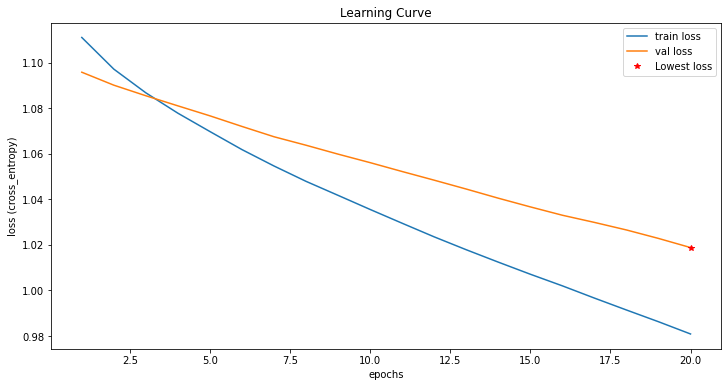

In [22]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

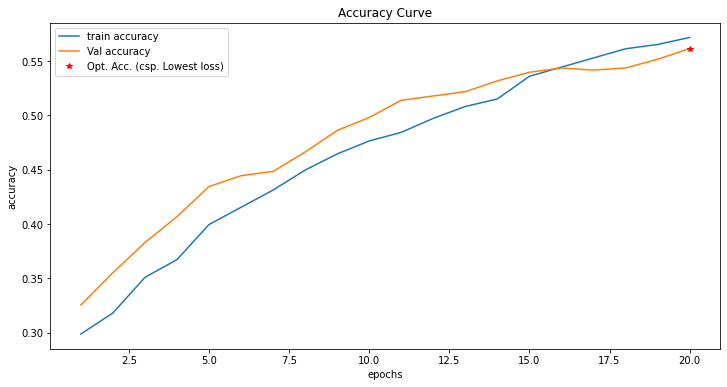

In [23]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

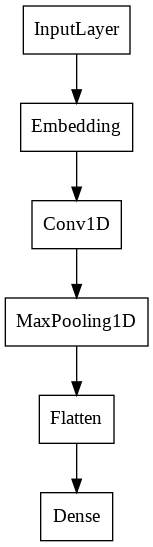

In [24]:
from keras.utils import plot_model
plot_model(model, to_file='RNN_LSTM_model.png', show_shapes=False, show_layer_names=False)